Linear Regression Customisation

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load the diabetes dataset from statsmodels or sklearn
from sklearn.datasets import load_diabetes

# Load the dataset and convert to DataFrame
data = load_diabetes(as_frame=True)
df = data.frame

# Add a target column name
df['target'] = data.target
print(df.head())


        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0  


In [3]:
# Add a lag feature for BMI (analogous to lagging vote share)
df['lagged_bmi'] = df['bmi'].shift(1)

# Add a categorical variable (e.g., discretize age into bins)
df['age_category'] = pd.cut(df['age'], bins=3, labels=['young', 'middle-aged', 'old'])

# Drop missing rows due to lagging
df = df.dropna()


In [4]:
# Create dummy variables for the categorical variable
age_dummies = pd.get_dummies(df['age_category'], prefix='age', drop_first=True)

# Concatenate the dummy variables to the main DataFrame
df = pd.concat([df, age_dummies], axis=1)


In [7]:
print(X_with_const.dtypes)
print(y.dtypes)


const              float64
bmi                float64
lagged_bmi         float64
age_middle-aged       bool
age_old               bool
dtype: object
float64


In [8]:
print(X_with_const.isnull().sum())  # Missing values in design matrix
print(y.isnull().sum())            # Missing values in target variable


const              0
bmi                0
lagged_bmi         0
age_middle-aged    0
age_old            0
dtype: int64
0


In [9]:
# Convert boolean columns to numeric
X_with_const['age_middle-aged'] = X_with_const['age_middle-aged'].astype(float)
X_with_const['age_old'] = X_with_const['age_old'].astype(float)

# Fit the linear regression model
model = sm.OLS(y, X_with_const).fit()

# Print the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     59.37
Date:                Wed, 27 Nov 2024   Prob (F-statistic):           5.29e-40
Time:                        23:19:58   Log-Likelihood:                -2446.0
No. Observations:                 441   AIC:                             4902.
Df Residuals:                     436   BIC:                             4922.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             145.8203      5.820     

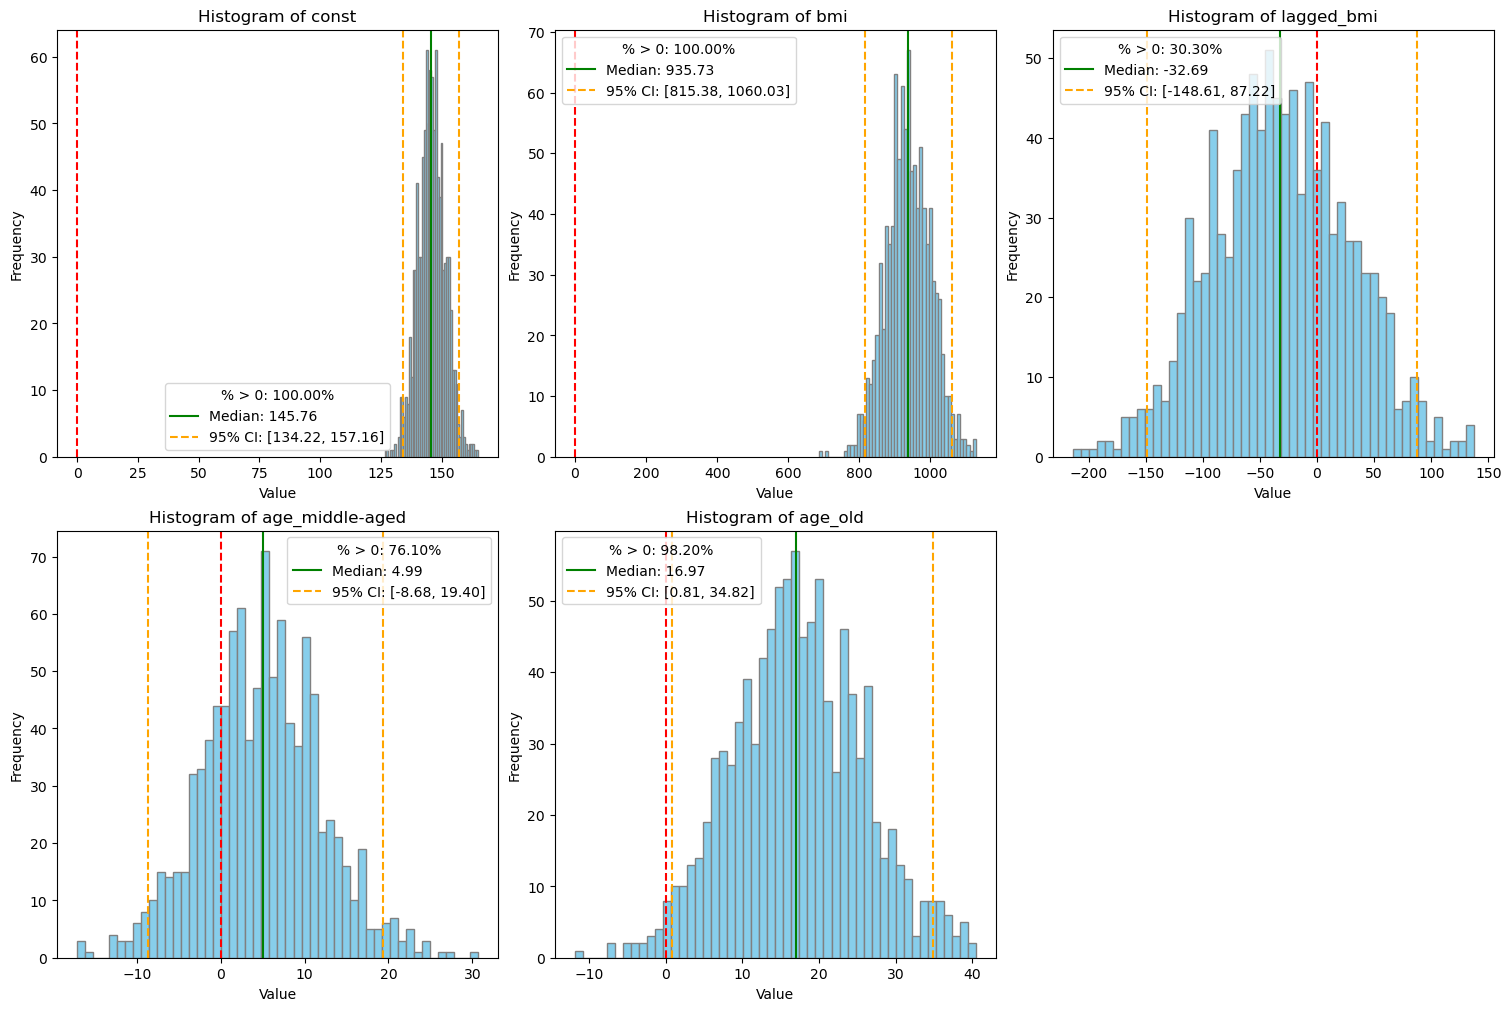

In [11]:
# Simulate values from empirical posterior distribution
coeff_samples = np.random.multivariate_normal(model.params, model.cov_params(), 1000)

# Extract parameter names dynamically
parameter_names = model.params.index.tolist()
n_params = len(parameter_names)

# Plotting histograms for coefficients
n_cols = min(3, n_params)
n_rows = (n_params + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), constrained_layout=True)
axes_flat = axes.flatten()

for i, name in enumerate(parameter_names):
    mean_val = np.mean(coeff_samples[:, i])
    median_val = np.median(coeff_samples[:, i])
    ci_lower, ci_upper = np.percentile(coeff_samples[:, i], [2.5, 97.5])
    percent_positive = np.mean(coeff_samples[:, i] > 0) * 100

    ax = axes_flat[i]
    ax.hist(coeff_samples[:, i], bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=ci_lower, color='orange', linestyle='--', label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]')
    ax.axvline(x=ci_upper, color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(title=f'% > 0: {percent_positive:.2f}%')

# Hide unused subplots
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.show()


In [12]:
# Predict new values (fitted values)
new_predictions = model.predict(X_with_const)

# Simulate fitted values
fitted_value_samples = X_with_const @ coeff_samples.T

# Calculate median and prediction intervals for fitted values
monte_carlo_medians = np.median(fitted_value_samples, axis=1)
prediction_intervals = np.percentile(fitted_value_samples, [2.5, 97.5], axis=1)

# Print results
print("Median of fitted values (per observation):", monte_carlo_medians)
print("95% Prediction intervals:", prediction_intervals)


Median of fitted values (per observation): [100.22025111261178 206.03861713075017 133.5831167182755
 117.12435370657663 108.87539464526608 102.87430101044728
 162.53733755126862 220.66513883658405 180.4131017642249 66.02901590224369
 169.89153490686428 123.01042260233976 149.8886765596978
 138.93839438845424 129.61904185732016 191.08093596896768
 172.8959648762709 135.63969784859196 134.22115919312432 93.05256712136115
 126.65644905580314 142.7226629987693 219.7383093032671 177.4139746094882
 132.84110575184218 73.80799333333857 209.01159647178105
 141.10027572407546 157.8756604893191 187.61000361895188 87.74525869759321
 270.24872119721624 99.65636407780306 93.0432950224332 135.91145366669627
 173.15661465219443 160.28994029648712 217.29370002883002
 161.54938313052892 142.29224113180135 82.79303158147799 138.1209187344959
 129.13404415155446 227.45246025547897 115.42936691725681
 136.13217998868583 77.91636708249735 126.10896445836153 160.4208149944535
 143.3220312437033 178.49551654

In [14]:
print(monte_carlo_medians.shape)
print(y.shape)


(441,)
(441,)


In [15]:
print(type(monte_carlo_medians), monte_carlo_medians.dtype)
print(type(y), y.dtype)


<class 'numpy.ndarray'> object
<class 'pandas.core.series.Series'> float64


In [17]:
monte_carlo_medians = pd.to_numeric(monte_carlo_medians, errors='coerce')


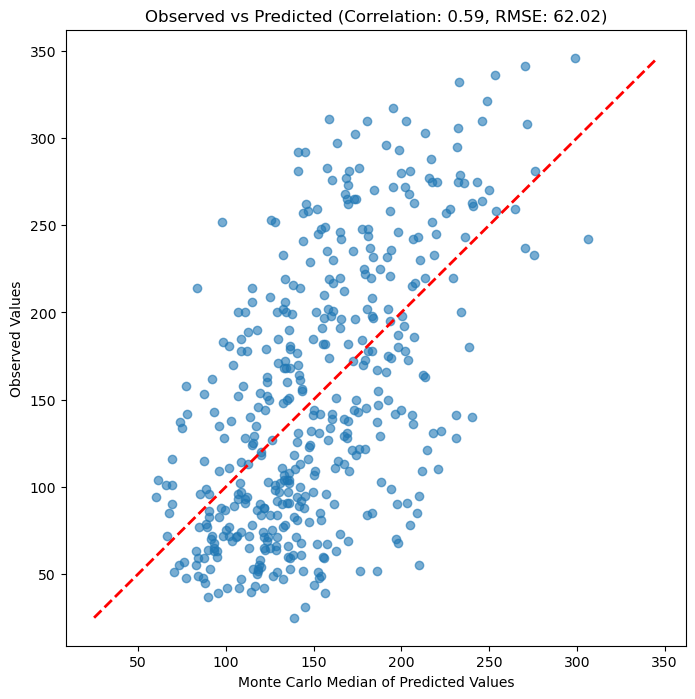

In [18]:
from sklearn.metrics import mean_squared_error

# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y)[0, 1]
rmse = np.sqrt(mean_squared_error(y, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y)
coverage = np.mean((y >= prediction_intervals[0, :]) & (y <= prediction_intervals[1, :]))

# Observed vs Predicted Values Plot
plt.figure(figsize=(8, 8))
plt.scatter(monte_carlo_medians, y, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Monte Carlo Median of Predicted Values')
plt.ylabel('Observed Values')
plt.title(f'Observed vs Predicted (Correlation: {correlation:.2f}, RMSE: {rmse:.2f})')
plt.show()
